# Import Libraries

In [1]:
# Data Loading
import pandas as pd

# Data Preprocessing
from sklearn.model_selection import train_test_split
from pandas.api.types import CategoricalDtype

# Pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.feature_selection import mutual_info_classif, SelectKBest
import numpy as np

# Sequential
import tensorflow as tf
import tensorflow_addons as tfa
from IPython.display import Image

# Model Evaluation
from sklearn.metrics import classification_report, precision_recall_curve
import matplotlib.pyplot as plt

# Data Loading

In [2]:
df = pd.read_csv('./WA_Fn-UseC_-Telco-Customer-Churn.csv')

In [3]:
# Convert TotalCharges type from string to number
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
# specific to this data set. tenure 0 always total charges 0.
df['TotalCharges'].fillna(0, inplace=True)

# Data Preprocessing

In [4]:
# Split data set
X = df.drop('Churn', axis=1)
y = df['Churn']
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.15, stratify=y, random_state=0)
X_train, X_val, y_train, y_val= train_test_split(
    X_train_val, y_train_val, test_size=0.15, stratify=y_train_val, random_state=0)

In [5]:
# Define data type
nom_cols = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 
            'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 
            'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 
            'PaperlessBilling', 'PaymentMethod']
ord_cols = ['Contract']
num_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']

In [6]:
# Change dtypes for OrdinalEncoder or OneHotEncoder
X_train_val['Contract'] = X_train_val['Contract'].astype(
    CategoricalDtype(
        categories=['Month-to-month', 'One year', 'Two year'], ordered=True)
)

X_train_val[nom_cols] = X_train_val[nom_cols].astype('category')

# Pipeline

In [7]:
num_pipe = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ]
)

nom_cats = [
    X_train_val['gender'].cat.categories.tolist(),
    X_train_val['SeniorCitizen'].cat.categories.tolist(),
    X_train_val['Partner'].cat.categories.tolist(),
    X_train_val['Dependents'].cat.categories.tolist(),
    X_train_val['PhoneService'].cat.categories.tolist(),
    X_train_val['MultipleLines'].cat.categories.tolist(),
    X_train_val['InternetService'].cat.categories.tolist(),
    X_train_val['OnlineSecurity'].cat.categories.tolist(),
    X_train_val['OnlineBackup'].cat.categories.tolist(),
    X_train_val['DeviceProtection'].cat.categories.tolist(),
    X_train_val['TechSupport'].cat.categories.tolist(),
    X_train_val['StreamingTV'].cat.categories.tolist(),
    X_train_val['StreamingMovies'].cat.categories.tolist(),
    X_train_val['PaperlessBilling'].cat.categories.tolist(),
    X_train_val['PaymentMethod'].cat.categories.tolist()
]

nom_pipe = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(categories=nom_cats)),
    ]
)

ord_pipe = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OrdinalEncoder(
            categories=[
                X_train_val['Contract'].cat.categories.tolist()
            ]
        )),
    ]
)

composer = ColumnTransformer(
    transformers=[
        ('num_pipe', num_pipe, num_cols),
        ('nom_pipe', nom_pipe, nom_cols),
        ('ord_pipe', ord_pipe, ord_cols)
    ]
)

In [8]:
# Get discrete features bool
composer.fit(X=X_train, y=y_train)
print([feature.startswith(("nom", "ord")) for feature in composer.get_feature_names_out()])

[False, False, False, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True]


In [9]:
def isolate():
    X_train_final = composer.transform(X=X_train)
    
    mi = mutual_info_classif(
            X=X_train_final, y=y_train,
            discrete_features=[False, False, False, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True],
            random_state=0
    )
    
    df_c = pd.DataFrame()
    df_c["mi"] = mi / np.max(mi)
    
    df_c["feature"] = composer.get_feature_names_out()
    display(df_c.sort_values(by="mi", ascending=False)
                .reset_index()
                .style.background_gradient(cmap="coolwarm"))

isolate()

,index,mi,feature
0,43,1.000000,ord_pipe__Contract
1,0,0.747704,num_pipe__tenure
2,19,0.609299,nom_pipe__OnlineSecurity_No
3,28,0.561733,nom_pipe__TechSupport_No
4,17,0.483557,nom_pipe__InternetService_Fiber optic
5,2,0.449007,num_pipe__TotalCharges
6,41,0.436607,nom_pipe__PaymentMethod_Electronic check
7,1,0.402054,num_pipe__MonthlyCharges
8,22,0.381612,nom_pipe__OnlineBackup_No
9,25,0.340230,nom_pipe__DeviceProtection_No


# Preprocessor

In [10]:
def sel_score(X, y):
    return mutual_info_classif(
        X=X, y=y, 
        discrete_features=[False, False, False, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True],
        random_state=0
    )

In [11]:
# Define preprocessor
preprocessor = Pipeline(
    steps=[
        ('composer', composer),
        ('sel', SelectKBest(
            score_func=sel_score,
            k=17,
        ))
    ]
)
preprocessor.fit(X=X_train, y=y_train)

# Define the scaled and encoded data set
X_train_final = preprocessor.transform(X=X_train)
y_train_final = y_train.map({'No': 0, 'Yes': 1})

X_val_final = preprocessor.transform(X=X_val)
y_val_final = y_val.map({'No': 0, 'Yes': 1})

X_test_final = preprocessor.transform(X=X_test)
y_test_final = y_test.map({'No': 0, 'Yes': 1})

# Tensorflow Pipeline

In [12]:
train_pipe = tf.data.Dataset.from_tensor_slices((X_train_final, y_train_final)) \
                            .shuffle(3) \
                            .batch(36) \
                            .prefetch(buffer_size=tf.data.AUTOTUNE)
val_pipe = tf.data.Dataset.from_tensor_slices((X_val_final, y_val_final)) \
                          .batch(36)
test_pipe = tf.data.Dataset.from_tensor_slices((X_test_final,  y_test_final)) \
                           .batch(36)

Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-12-04 13:28:54.474709: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-04 13:28:54.474833: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


# Sequential API

In [13]:
# Define sequential improved

seq_imp = tf.keras.Sequential(
    layers=[
        tf.keras.Input(shape=(17,)),
        
        tf.keras.layers.Dense(
            units=4, use_bias=True,
            kernel_initializer=tf.keras.initializers.HeNormal(seed=0)
        ),
        
        tf.keras.layers.BatchNormalization(),
        
        tf.keras.layers.LeakyReLU(alpha=0.3),
        
        tf.keras.layers.Dense(units=1, use_bias=True, activation='sigmoid')
    ]
)

seq_imp.compile(
    optimizer=tf.keras.optimizers.SGD(),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[
        tfa.metrics.F1Score(
            num_classes=1,
            average='macro',
            threshold=0.5
        )
    ]
)

seq_imp.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 4)                 72        
                                                                 
 batch_normalization (BatchN  (None, 4)                16        
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 4)                 0         
                                                                 
 dense_1 (Dense)             (None, 1)                 5         
                                                                 
Total params: 93
Trainable params: 85
Non-trainable params: 8
_________________________________________________________________


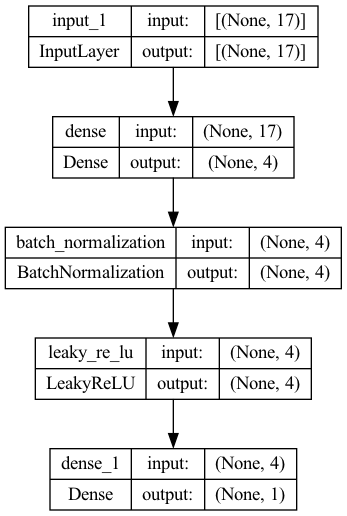

In [14]:
# Plot the sequential improved

def isolate():
    
    plt = Image(tf.keras.utils.model_to_dot(seq_imp, show_shapes=True).create_png())
    display(plt)

isolate()

In [15]:
# Train the sequential improved

callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_f1_score",
    mode="max",
    patience=10,
    min_delta=0.0001,
    restore_best_weights=True
)

hist_seq_imp = seq_imp.fit(
    train_pipe,
    validation_data=val_pipe,
    epochs=100,
    callbacks=[callback]
)

Epoch 1/100


2022-12-04 13:28:55.556628: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-12-04 13:28:55.556986: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


142/142 [==============================] - ETA: 0s - loss: 0.5338 - f1_score: 0.3850

2022-12-04 13:28:57.262813: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


142/142 [==============================] - 2s 12ms/step - loss: 0.5338 - f1_score: 0.3850 - val_loss: 0.5111 - val_f1_score: 0.4178
Epoch 2/100
142/142 [==============================] - 1s 11ms/step - loss: 0.4914 - f1_score: 0.4451 - val_loss: 0.4863 - val_f1_score: 0.4888
Epoch 3/100
142/142 [==============================] - 1s 10ms/step - loss: 0.4730 - f1_score: 0.4578 - val_loss: 0.4750 - val_f1_score: 0.4926
Epoch 4/100
142/142 [==============================] - 1s 9ms/step - loss: 0.4626 - f1_score: 0.4730 - val_loss: 0.4686 - val_f1_score: 0.4853
Epoch 5/100
142/142 [==============================] - 1s 9ms/step - loss: 0.4555 - f1_score: 0.4878 - val_loss: 0.4642 - val_f1_score: 0.4703
Epoch 6/100
142/142 [==============================] - 1s 9ms/step - loss: 0.4528 - f1_score: 0.4882 - val_loss: 0.4609 - val_f1_score: 0.4729
Epoch 7/100
142/142 [==============================] - 1s 9ms/step - loss: 0.4492 - f1_score: 0.4911 - val_loss: 0.4581 - val_f1_score: 0.4804
Epoch 8/

val_f1_score max 0.57
val_loss min 0.44


<AxesSubplot: >

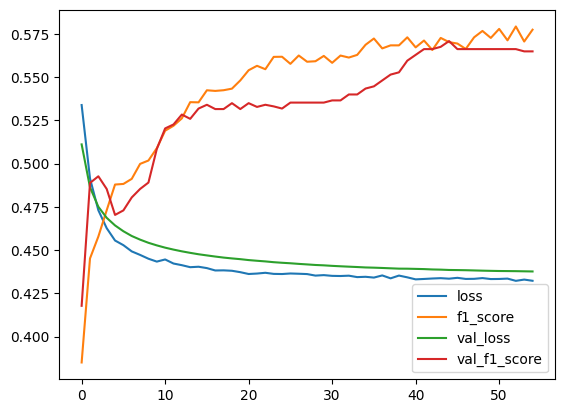

In [16]:
# Visualize the sequential improved metrics

hist_seq_imp_df = pd.DataFrame(data=hist_seq_imp.history)

print("val_f1_score max %.2f" % (np.max(hist_seq_imp_df['val_f1_score'])))
print("val_loss min %.2f" % (np.min(hist_seq_imp_df['val_loss'])))

hist_seq_imp_df.plot()

In [17]:
# Prevent data leakage.
seq_imp.trainable = False

In [18]:
# Evaluating the model sequential improved

y_pred_seq_imp = seq_imp.predict(x=X_test_final)
y_pred_seq_imp = np.where(y_pred_seq_imp >= 0.5, 1, 0)

print(classification_report(y_test_final, y_pred_seq_imp))

34/34 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0       0.85      0.89      0.86       777
           1       0.63      0.55      0.59       280

    accuracy                           0.80      1057
   macro avg       0.74      0.72      0.73      1057
weighted avg       0.79      0.80      0.79      1057



2022-12-04 13:30:08.089548: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


# Threshold Tuning

34/34 [==============================] - 0s 2ms/step
Best Threshold=0.288309, F-Score=0.643


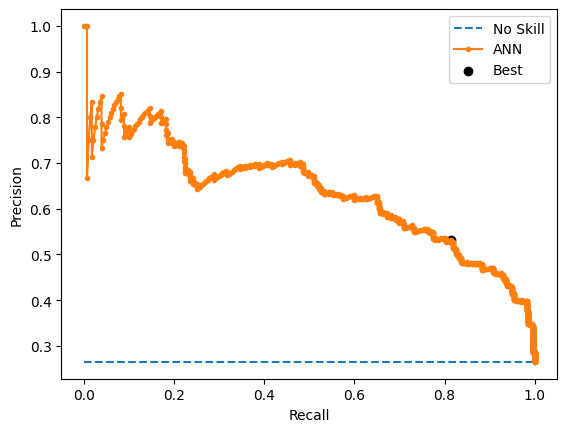

In [19]:
# Evaluating the model sequential improved

y_pred_seq_imp = seq_imp.predict(x=X_test_final)
precision, recall, thresholds = precision_recall_curve(y_test_final, y_pred_seq_imp)
fscore = (2 * precision * recall) / (precision + recall)
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))
no_skill = len(y_test_final[y_test_final==1]) / len(y_test_final)
plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
plt.plot(recall, precision, marker='.', label='ANN')
plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

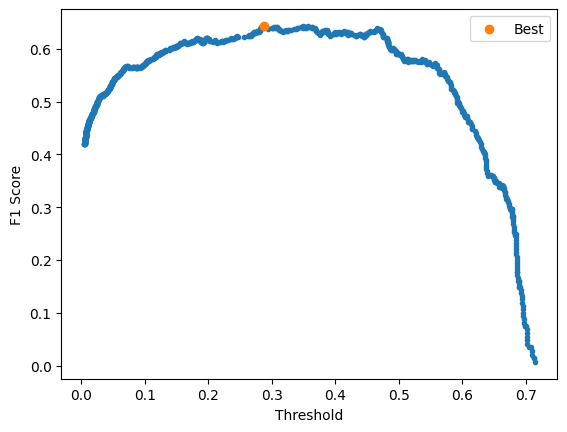

In [20]:
# Threshold, F1 Score

plt.scatter(thresholds, fscore[:-1], marker='.')
plt.scatter(thresholds[ix], fscore[ix], marker='o', label='Best')
plt.xlabel("Threshold")
plt.ylabel("F1 Score")
plt.legend()
plt.show()

In [21]:
# Evaluating the model sequential improved

y_pred_seq_imp = seq_imp.predict(x=X_test_final)
y_pred_seq_imp = np.where(y_pred_seq_imp >= thresholds[ix], 1, 0)

print(classification_report(y_test_final, y_pred_seq_imp))

34/34 [==============================] - 0s 4ms/step
              precision    recall  f1-score   support

           0       0.92      0.74      0.82       777
           1       0.53      0.81      0.64       280

    accuracy                           0.76      1057
   macro avg       0.72      0.78      0.73      1057
weighted avg       0.82      0.76      0.77      1057

